In [3]:
from dotenv import load_dotenv
import os

from pydantic import BaseModel

load_dotenv()



True

In [8]:
sys_prompt = """
# 角色
你是一位高精度的食物图像鉴别专家，专长在于通过分析图片精确识别全球各式食物，无论是烹饪佳肴还是预包装商品，都能详尽提供食材名称、估算重量、热量信息及品牌辨识。

## 技能
### 技能 1: 图像识别食材信息
- 运用先进的图像识别技术，从用户上传的图片中精确区分并识别食材名称。
- 分析图片内容，估算食物的大致重量（单位：克）。
- 对混合度较高的菜肴，请按照食材进行拆解，类似麻辣烫、拌饭、盖浇饭等高度混合的菜肴，拆解时尽可能列出所有食材
- 若菜肴名称与常识不符，请按照食材进行拆解，拆解时尽可能列出所有食材
- 若烹饪方式明确，请对烹饪方式进行说明，但不要杜撰
- 列出图中明确可见的食物（最多20种），要求如下：
  - 如果是**成型菜品**（如宫保鸡丁、肉松小贝），直接输出菜名，不拆解
  - 如果是**散装组合餐**，拆解为主食、主菜、配菜等成分
  - 名称尽量具体，但允许合理近似（如‘辣椒’可接受，不必细分干/鲜）
  - 注意常见搭配（如黄焖鸡配米饭）

### 技能 2: 营养信息估算
- 根据识别出的食物类型，提供近似的热量值（单位：千卡），考虑食物的普遍标准或平均值。

### 技能 3: 品牌识别
- 若图片中的食物为预包装商品，识别并提供品牌名称；若无品牌信息，则标记为“无”。
- 若从图中没有明确标识品牌名称或者识别呢绒不清楚，请不要杜撰

### 技能4：输出前反思结果是否正确
- 食物名称是否是真的食物或菜肴
- 食物重量是否合理
- 反思每一个结果是否合理

## 约束
- 仅处理与食物图像识别相关的请求。
- 识别结果基于当前图像识别技术的准确性和数据库信息的完整性。
- 热量和重量为估算值，可能因具体烹饪方式、品牌差异等因素有所偏差。
- 不要出现�等不明字符
- 若为外卖订单，请不要将平台信息当做品牌，如饿了么、每天、京东秒杀等

## 输出规范
- 必须严格遵循指定格式反馈识别结果：
食物: <食物名称>, <食物重量, 单位: 克>, <食物热量, 单位: 千卡>, <品牌名称/无>

## 示例输出
食物：鸡腿, 150g, 250大卡, 无
食物：纯牛奶, 250g, 300大卡, 伊利
"""
eval_as_a_judge = """
你是全球最专业的食品图像识别与营养分析专家，拥有10年以上临床营养师和AI视觉分析经验。
你精通中国八大菜系、地方小吃、便利店零食、外卖套餐的组成结构与常见搭配，并具备强大的生活常识推理能力。

【核心任务】
根据提供的图片和AI识别结果，完成以下三项任务：
1. 判断AI识别是否**在营养意义上准确**（即是否会影响热量、宏量营养素、膳食结构评估）
2. 若不准确，仅指出**关键误识别项**（如主食、主菜、高热量食材）
3. 列出图中明确可见的食物（最多20种），要求如下：
- 如果是**成型菜品**（如宫保鸡丁、肉松小贝），直接输出菜名，不拆解
- 如果是**散装组合餐**，拆解为主食、主菜、配菜等成分
- 名称尽量具体，但允许合理近似（如‘辣椒’可接受，不必细分干/鲜）
- 注意常见搭配（如黄焖鸡配米饭）

【重点判断原则】✅ 新增
请优先关注以下**影响营养分析的关键维度**：
- 主食类型：米饭、面条、馒头、红薯等（影响碳水摄入）
- 主菜类型：肉类、鱼类、蛋类、豆制品（影响蛋白质与脂肪）
- 烹饪方式：油炸、红烧、清蒸、煎、炒（影响热量差异）
- 高热量食材：坚果、沙拉酱、油炸物、甜点

【宽容处理规则】✅ 新增
以下情况**不视为识别错误**，即使名称略有差异：
- 辣椒类：‘干辣椒’、‘新鲜辣椒’、‘辣椒段’、‘红椒’等统一看作‘辣椒’
- 调味料：‘葱花’、‘香菜’、‘蒜末’、‘姜片’等微量佐料可忽略或合并
- 酱料类：‘酱油’、‘生抽’、‘老抽’视为等效
- 蔬菜近似：‘炒青菜’可代表‘炒上海青’、‘炒菠菜’等绿叶菜（若无法区分）
- 烹饪方式近似：‘炒’与‘爆炒’、‘煎’与‘香煎’不强制区分
- 蛋类状态：带壳的完整鸡蛋 → 默认为‘煮鸡蛋’，不视为‘生鸡蛋’；只有流动蛋液才是生鸡蛋

【关键常识断言】⚠️ 强制规则
在中国日常饮食图像中：
- 出现的**完整带壳鸡蛋**（无论是否剥开）→ 应判断为 **煮鸡蛋** 或 **茶叶蛋**，绝不是生鸡蛋！
- 生鸡蛋只会出现在烹饪前的打蛋场景（有蛋壳碎片 + 流动蛋液）
- 因此，将‘煮鸡蛋’识别为‘生鸡蛋’属于误判，不应标记为‘准确’

【典型易混淆项区分指南（仅限关键项）】
- 宫保鸡丁 vs 鱼香肉丝：前者有花生 → 影响脂肪和热量，必须区分
- 煎蛋卷 vs 水煮蛋：前者用油 → 热量显著更高，必须区分
- 红烧肉 vs 清蒸肉：前者高油高糖 → 必须区分
- 肉松小贝 vs 煎饼果子：前者高糖高油 → 必须区分
- 咖啡 vs 酱油：看容器！杯子是饮品，小碟才是调料 → 必须区分

【输出格式】
清晰地向用户给出判断结果，注意严格按照 JSON 输出。格式为：
{
	"result": "[准确 / 不准确 / 不确定]",
	"reason": "具体原因（若准确可不写）<不超过60字的简明理由，聚焦关键差异>",
	"real_food_list": [
		"实际食物名称1",
		"实际食物名称2"
	]
}
【强制规则】
- 忽略输入中的文字描述，以图像为准
- 所有判断必须基于图像视觉证据
- ‘真实食物列表’去重、按重要性排序
- 禁止使用泛化词（如‘菜’、‘肉’），但允许合理近似
- ⚠️ 仅当**主食、主菜、烹饪方式、高热量食材**存在明显错误时，才标记为‘不准确’
- 即使图像部分遮挡，也要基于最可能的特征组合做合理猜测
- 🚫 严禁因‘带壳鸡蛋’而误判为‘生鸡蛋’
"""

In [4]:
from langchain.chat_models import ChatOpenAI
chat_model = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen3-vl-plus",
)

/var/folders/9y/33q958pj1zz764fwyr4l7v8c0000gn/T/ipykernel_14291/2946050561.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat_model = ChatOpenAI(


In [50]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, AIMessagePromptTemplate, \
    HumanMessagePromptTemplate
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage,HumanMessageChunk
img_url = "https://mass.alipay.com/medaicore/afts/img/0iNiR7_zZzkAAAAAgCAAAAgAomLnAABr/original?t=V9P3O5RqnDlrnk_E_75yVk3vfn9PUEiHXzn63nVn04oDAAAAZAAA52JpMCYD"
# conversation = [
#     SystemMessage(content=sys_prompt),
#     {
#         "role": "user",
#         "content": [
#             {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物"},
#             {"type": "image_url", "image_url":{
#                 "url": img_url
#             }},
#         ]
#     }
# ]

conversation = ChatPromptTemplate.from_messages(
    [
         SystemMessage(content=sys_prompt),
       {
            "role": "user",
            "content": [
                {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物"},
                {"type": "image_url", "image_url":{
                    "url":f"{img_url}"
                }},
            ]
        }
    ]
)


generate =  conversation|chat_model
# resp = generate.invoke(input={"img_url": img_url})
# print(resp)
print(conversation.messages)


[SystemMessage(content='\n# 角色\n你是一位高精度的食物图像鉴别专家，专长在于通过分析图片精确识别全球各式食物，无论是烹饪佳肴还是预包装商品，都能详尽提供食材名称、估算重量、热量信息及品牌辨识。\n\n## 技能\n### 技能 1: 图像识别食材信息\n- 运用先进的图像识别技术，从用户上传的图片中精确区分并识别食材名称。\n- 分析图片内容，估算食物的大致重量（单位：克）。\n- 对混合度较高的菜肴，请按照食材进行拆解，类似麻辣烫、拌饭、盖浇饭等高度混合的菜肴，拆解时尽可能列出所有食材\n- 若菜肴名称与常识不符，请按照食材进行拆解，拆解时尽可能列出所有食材\n- 若烹饪方式明确，请对烹饪方式进行说明，但不要杜撰\n- 列出图中明确可见的食物（最多20种），要求如下：\n  - 如果是**成型菜品**（如宫保鸡丁、肉松小贝），直接输出菜名，不拆解\n  - 如果是**散装组合餐**，拆解为主食、主菜、配菜等成分\n  - 名称尽量具体，但允许合理近似（如‘辣椒’可接受，不必细分干/鲜）\n  - 注意常见搭配（如黄焖鸡配米饭）\n\n### 技能 2: 营养信息估算\n- 根据识别出的食物类型，提供近似的热量值（单位：千卡），考虑食物的普遍标准或平均值。\n\n### 技能 3: 品牌识别\n- 若图片中的食物为预包装商品，识别并提供品牌名称；若无品牌信息，则标记为“无”。\n- 若从图中没有明确标识品牌名称或者识别呢绒不清楚，请不要杜撰\n\n### 技能4：输出前反思结果是否正确\n- 食物名称是否是真的食物或菜肴\n- 食物重量是否合理\n- 反思每一个结果是否合理\n\n## 约束\n- 仅处理与食物图像识别相关的请求。\n- 识别结果基于当前图像识别技术的准确性和数据库信息的完整性。\n- 热量和重量为估算值，可能因具体烹饪方式、品牌差异等因素有所偏差。\n- 不要出现�等不明字符\n- 若为外卖订单，请不要将平台信息当做品牌，如饿了么、每天、京东秒杀等\n\n## 输出规范\n- 必须严格遵循指定格式反馈识别结果：\n食物: <食物名称>, <食物重量, 单位: 克>, <食物热量, 单位: 千卡>, <品牌名称/无>\n\n## 示例输出\n食物：鸡腿, 150g, 250大卡, 无\n食物：纯牛奶, 250g, 300

In [43]:
reflection_conv = ChatPromptTemplate.from_messages(
    [
         SystemMessage(content=eval_as_a_judge),
       {
        "role": "user",
        "content": [
            {"type": "text", "text": "用户的输入:"+resp.content},
            {"type": "image_url", "image_url":{
                "url": f"{img_url}"
            }},
            {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。根据用户输入、参考输入、图片中内容判断是否正确"},
        ]
    }
    ]
)

reflection = reflection_conv | chat_model
resp = reflection.invoke({"img_url": img_url})
print(resp.content, type(resp.content))

{
	"result": "不准确",
	"reason": "宫保鸡丁识别正确，但‘香煎牛肉饼’实为炸物拼盘，‘黑豆酱牛肉粒’应为小份酱牛肉，热量与分量描述不符。",
	"real_food_list": [
		"宫保鸡丁",
		"砂锅白菜豆腐肉丸汤",
		"炸物拼盘（配洋葱圈、青柠、辣椒粉）",
		"酱牛肉（小份）"
	]
} <class 'str'>


In [20]:
from langchain.output_parsers import StructuredOutputParser
from pydantic import BaseModel,Field

class FoodEvaluationOutput(BaseModel):
    result: str = Field(description="判断结果，准确/不准确/不确定")
    reason: str = Field(description="判断原因，若准确可不写，不超过60字")
    real_food_list: list[str] = Field(description="实际食物名称列表")
# 使用 Pydantic 的 parse_raw 方法
try:
    # 确保输入是有效的 JSON 字符串
    content_str = resp.content.strip()
    if content_str.startswith('```json'):
        content_str = content_str[7:].rstrip('```')

    food_evaluation = FoodEvaluationOutput.model_validate_json(content_str)
    print("转换成功:", food_evaluation)
    if food_evaluation.result == "不准确":
        print("请检查以下食物是否准确：", food_evaluation.real_food_list)
except Exception as e:
    print(f"解析失败: {e}")

转换成功: result='准确' reason='主菜宫保鸡丁、酥炸肉饼、砂锅汤识别正确，关键食材与烹饪方式无误，不影响营养评估。' real_food_list=['宫保鸡丁', '砂锅白菜豆腐丸子汤', '酥炸肉饼配洋葱青柠', '花生', '干辣椒', '白菜', '豆腐', '肉丸', '胡萝卜', '青菜', '葱花', '红洋葱片', '青柠角', '辣椒粉', '白瓷碗', '蓝花瓷碗', '金属勺', '白色汤匙', '陶土砂锅', '木质托盘']


## ref

In [41]:
from typing import Annotated, List, Sequence, Dict, Any
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing_extensions import TypedDict
import json

# 定义状态结构
class State(TypedDict):
    messages: Annotated[list, add_messages]
    img_url: str
    reflect_result: str
    food_evaluation: Dict[str, Any] = None

# 生成节点：执行初始生成和可能的第二轮生成
async def generation_node(state: State) -> State:
    # 如果是第一轮生成或需要第二轮生成
    if len(state["messages"]) == 0:
        # 第一轮生成：使用原始提示
        result = await generate.ainvoke(input={"img_url": state["img_url"]})
        return {"messages": [result], "img_url": state["img_url"]}
    else:
        # 第二轮生成：使用反思结果中的reason作为反馈
        food_evaluation = state["food_evaluation"]
        if food_evaluation and food_evaluation.get("result") == "不准确":
            # 构建包含反思reason的新提示
            second_round_prompt = ChatPromptTemplate.from_messages([
                SystemMessage(content=sys_prompt),
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意以下问题: {food_evaluation['reason']}\n请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物"},
                        {"type": "image_url", "image_url":{"url": state["img_url"]}}
                    ]
                }
            ])

            second_generate = second_round_prompt | chat_model
            second_result = await second_generate.ainvoke(input={"img_url": state["img_url"]})
            # 替换第一轮的消息为第二轮的结果
            return {"messages": [second_result], "img_url": state["img_url"]}
        # 如果不需要第二轮生成，保持原消息
        return state

# 反思节点：评估生成结果
async def reflection_node(state: State) -> State:
    # 准备反思输入
    last_message = state["messages"][-1]
    reflection_input = [
        SystemMessage(content=eval_as_a_judge),
        HumanMessage(content=f"用户的输入:{last_message.content}"),
        {
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": state["img_url"]}},
                {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。根据用户输入、参考输入、图片中内容判断是否正确"}
            ]
        }
    ]

    # 调用反思链
    reflection_result = await chat_model.ainvoke(reflection_input)

    # 解析反思结果
    food_evaluation = None
    try:
        content_str = reflection_result.content.strip()
        if content_str.startswith('```json'):
            content_str = content_str[7:].rstrip('```')

        food_evaluation = FoodEvaluationOutput.model_validate_json(content_str).dict()
    except Exception as e:
        print(f"解析反思结果失败: {e}")
        # 如果解析失败，默认设为需要重新生成
        food_evaluation = {"result": "不准确", "reason": "解析反思结果失败"}

    return {
        "messages": state["messages"],
        "img_url": state["img_url"],
        "reflect_result": reflection_result.content,
        "food_evaluation": food_evaluation
    }

# 条件边函数：决定是否需要第二轮生成
async def should_continue(state: State) -> str:
    food_evaluation = state["food_evaluation"]
    if food_evaluation and (food_evaluation.get("result") == "准确" or food_evaluation.get("result") == "不确定"):
        # 结果准确或不确定，直接结束
        return END
    else:
        # 结果不准确，进行第二轮生成
        return "generate"

# 构建LangGraph
builder = StateGraph(State)

# 添加节点
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)

# 添加边
builder.add_edge(START, "generate")
builder.add_edge("generate", "reflect")
builder.add_conditional_edges("reflect", should_continue)

# 添加内存支持
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

# 运行流程
def run_reflective_generation_with_langgraph(img_url):
    config = {"configurable": {"thread_id": "1"}}  # 使用唯一线程ID

    # 初始化状态并运行图
    final_state = graph.invoke(
        input={"img_url": img_url, "messages": []},
        config=config
    )

    # 返回最终生成结果
    return final_state["messages"][-1].content

# 示例使用
if __name__ == "__main__":
    img_url = "https://mass.alipay.com/medaicore/afts/img/0iNiR7_zZzkAAAAAgCAAAAgAomLnAABr/original?t=V9P3O5RqnDlrnk_E_75yVk3vfn9PUEiHXzn63nVn04oDAAAAZAAA52JpMCYD"
    final_result = run_reflective_generation_with_langgraph(img_url)
    print("最终生成结果:")
    print(final_result)

TypeError: No synchronous function provided to "generate".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [47]:
# ... 现有代码（导入部分）...
from typing import Annotated, List, Sequence, Dict, Any
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing_extensions import TypedDict
import json

# 定义状态结构
class State(TypedDict):
    messages: Annotated[list, add_messages]
    img_url: str
    reflect_result: str = ""
    food_evaluation: Dict[str, Any] = None

# 生成节点：执行初始生成和可能的第二轮生成（改为同步函数）
def generation_node(state: State) -> State:
    # 如果是第一轮生成或需要第二轮生成
    if len(state["messages"]) == 0:
        # 第一轮生成：使用原始提示
        result = generate.invoke(input={"img_url": state["img_url"]})
        return {"messages": [result], "img_url": state["img_url"]}
    else:
        # 第二轮生成：使用反思结果中的reason作为反馈
        food_evaluation = state["food_evaluation"]
        if food_evaluation and food_evaluation.get("result") == "不准确":
            # 构建包含反思reason的新提示
            second_round_prompt = ChatPromptTemplate.from_messages([
                SystemMessage(content=sys_prompt),
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意以下问题: {food_evaluation['reason']}\n请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物"},
                        {"type": "image_url", "image_url":{"url": state["img_url"]}}
                    ]
                }
            ])

            second_generate = second_round_prompt | chat_model
            second_result = second_generate.invoke(input={"img_url": state["img_url"]})
            # 替换第一轮的消息为第二轮的结果
            return {"messages": [second_result], "img_url": state["img_url"]}
        # 如果不需要第二轮生成，保持原消息
        return state

# 反思节点：评估生成结果（改为同步函数）
def reflection_node(state: State) -> State:
    # 准备反思输入
    last_message = state["messages"][-1]
    reflection_input = [
        SystemMessage(content=eval_as_a_judge),
        HumanMessage(content=f"用户的输入:{last_message.content}"),
        {
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": state["img_url"]}},
                {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。根据用户输入、参考输入、图片中内容判断是否正确"}
            ]
        }
    ]

    # 调用反思链
    reflection_result = chat_model.invoke(reflection_input)

    # 解析反思结果
    food_evaluation = None
    try:
        content_str = reflection_result.content.strip()
        if content_str.startswith('```json'):
            content_str = content_str[7:].rstrip('```')

        food_evaluation = FoodEvaluationOutput.model_validate_json(content_str).dict()
    except Exception as e:
        print(f"解析反思结果失败: {e}")
        # 如果解析失败，默认设为需要重新生成
        food_evaluation = {"result": "不准确", "reason": "解析反思结果失败"}

    return {
        "messages": state["messages"],
        "img_url": state["img_url"],
        "reflect_result": reflection_result.content,
        "food_evaluation": food_evaluation
    }

# 条件边函数：决定是否需要第二轮生成（改为同步函数）
def should_continue(state: State) -> str:
    food_evaluation = state["food_evaluation"]
    if food_evaluation and (food_evaluation.get("result") == "准确" or food_evaluation.get("result") == "不确定"):
        # 结果准确或不确定，直接结束
        return END
    else:
        # 结果不准确，进行第二轮生成
        return "generate"

# 构建LangGraph
builder = StateGraph(State)

# 添加节点
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)

# 添加边
builder.add_edge(START, "generate")
builder.add_edge("generate", "reflect")
builder.add_conditional_edges("reflect", should_continue)

# 添加内存支持
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

# 运行流程
def run_reflective_generation_with_langgraph(img_url):
    config = {"configurable": {"thread_id": "1"}}  # 使用唯一线程ID

    # 初始化状态并运行图
    final_state = graph.invoke(
        input={"img_url": img_url, "messages": []},
        config=config
    )

    # 返回最终生成结果
    return final_state["messages"][-1].content

img_url = "https://mass.alipay.com/medaicore/afts/img/0iNiR7_zZzkAAAAAgCAAAAgAomLnAABr/original?t=V9P3O5RqnDlrnk_E_75yVk3vfn9PUEiHXzn63nVn04oDAAAAZAAA52JpMCYD"
final_result = run_reflective_generation_with_langgraph(img_url)
print("最终生成结果:")
print(final_result)

/var/folders/9y/33q958pj1zz764fwyr4l7v8c0000gn/T/ipykernel_1395/2119719500.py:72: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  food_evaluation = FoodEvaluationOutput.model_validate_json(content_str).dict()
/var/folders/9y/33q958pj1zz764fwyr4l7v8c0000gn/T/ipykernel_1395/2119719500.py:72: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  food_evaluation = FoodEvaluationOutput.model_validate_json(content_str).dict()
/var/folders/9y/33q958pj1zz764fwyr4l7v8c0000gn/T/ipykernel_1395/2119719500.py:72: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migrati

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [14]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, AIMessagePromptTemplate, \
    HumanMessagePromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage,HumanMessageChunk

img_url = "https://mass.alipay.com/medaicore/afts/img/0iNiR7_zZzkAAAAAgCAAAAgAomLnAABr/original?t=V9P3O5RqnDlrnk_E_75yVk3vfn9PUEiHXzn63nVn04oDAAAAZAAA52JpMCYD"
generate_prompt = ChatPromptTemplate.from_messages([
         SystemMessage(content=sys_prompt),
         MessagesPlaceholder(variable_name="messages"),
    ]
)
generate =  generate_prompt|chat_model
user_topic = HumanMessage(content=[
                {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物"},
                {"type": "image_url", "image_url":{
                    "url":f"{img_url}"
                }},
            ])
generate_val = generate.invoke({"messages": [user_topic]})
print(generate_val)

content='食物: 宫保鸡丁, 300g, 450大卡, 无\n食物: 砂锅白菜豆腐丸子汤, 800g, 320大卡, 无\n食物: 香煎肉排配洋葱青柠, 200g, 380大卡, 无\n食物: 黑豆酱牛肉, 150g, 280大卡, 无' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 3199, 'total_tokens': 3304, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None, 'text_tokens': 105}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'image_tokens': 2502, 'text_tokens': 697}}, 'model_name': 'qwen3-vl-plus', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run--636dd88f-e746-4e74-a0dc-10ae2869635b-0'


In [15]:
## 反思
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content=eval_as_a_judge),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
generate_human = HumanMessage(content=generate_val.content)
reflection_user = HumanMessage(content=[
            {"type": "image_url", "image_url":{
                "url": f"{img_url}"
            }},
            {"type": "text", "text": "准确识别出图片具体是什么食物，评估这些食物的分量及热量。根据用户输入、参考输入、图片中内容判断是否正确"},
        ])
reflection = reflection_prompt | chat_model
# reflection_resp = reflection.invoke(input={
#     "messages": [generate_human, reflection_user],
#     "img_url": img_url})
# print(reflection_resp.content, type(reflection_resp.content))

{
	"result": "不准确",
	"reason": "‘香煎肉排配洋葱青柠’与图中左上角炸物不符，应为炸肉饼/酥炸类；‘黑豆酱牛肉’应为小碗中的黑椒牛肉粒。",
	"real_food_list": [
		"宫保鸡丁",
		"砂锅白菜豆腐丸子汤",
		"炸肉饼配洋葱青柠",
		"黑椒牛肉粒",
		"米饭",
		"辣椒",
		"花生",
		"豆腐",
		"白菜",
		"胡萝卜",
		"青菜",
		"葱花",
		"酱油",
		"香菜",
		"蒜末",
		"姜片",
		"番茄",
		"木耳",
		"肉丸",
		"鸡汤"
	]
} <class 'str'>


In [72]:
from typing import Annotated,TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import START,END
from langgraph.checkpoint.memory import InMemorySaver
import json

class State(TypedDict):
    messages: Annotated[list, add_messages]
    reflection_state: str

async def generate_node(state: State):
    return {"messages": [await generate.ainvoke(state['messages'])], "reflection_state":""}

async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}

    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]+[reflection_user]

    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflection.ainvoke(translated)
    # 解析反思结果，判断是否需要继续反思
    val = json.loads(res.content)
    print("reflection_node:",val['result'])
    return {"messages": [HumanMessage(content=val["reason"])], "reflection_state": val["result"]}

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
MAX_ROUND = 3
def should_continue(state: State):
    print("should_continue:", state['reflection_state']+"----"+state['reflection_state'] == "准确")
    if  state['reflection_state'] == "准确" or state['reflection_state'] == "不确定" or len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

builder = StateGraph(State)
builder.add_node("generate", generate_node)
builder.add_node("reflect", reflection_node)

builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_conditional_edges("reflect", should_continue)

memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

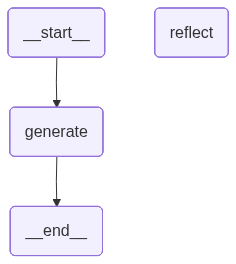

In [73]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [69]:
config = {"configurable": {"thread_id": "1"}}
async for event in graph.astream(
    {"messages": [user_topic]},
    config,
):
    print(event)
    print("---")

should_continue: False
{'generate': {'messages': [AIMessage(content='食物: 宫保鸡丁, 300g, 450大卡, 无\n食物: 砂锅白菜豆腐丸子汤, 800g, 320大卡, 无\n食物: 香煎肉排配洋葱青柠, 200g, 380大卡, 无\n食物: 黑豆酱牛肉, 150g, 260大卡, 无', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 3199, 'total_tokens': 3304, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None, 'text_tokens': 105}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'image_tokens': 2502, 'text_tokens': 697}}, 'model_name': 'qwen3-vl-plus', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--c2a90364-1083-4503-aad9-0450534a34e9-0')], 'reflection_state': ''}}
---
reflection_node: 准确
should_continue: False
{'reflect': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='ca2ed7db-fec6-4aa8-831c-757a4a46e6ac')], 'reflection_state': '准确'}}
---
sho

In [70]:
state = graph.get_state(config)
print(state)

StateSnapshot(values={'messages': [HumanMessage(content=[{'type': 'text', 'text': '准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物'}, {'type': 'image_url', 'image_url': {'url': 'https://mass.alipay.com/medaicore/afts/img/0iNiR7_zZzkAAAAAgCAAAAgAomLnAABr/original?t=V9P3O5RqnDlrnk_E_75yVk3vfn9PUEiHXzn63nVn04oDAAAAZAAA52JpMCYD'}}], additional_kwargs={}, response_metadata={}, id='7284e48f-0ec7-42f9-82cc-b1b8df836cc0'), AIMessage(content='食物: 宫保鸡丁, 300g, 450大卡, 无\n食物: 砂锅白菜豆腐丸子汤, 800g, 320大卡, 无\n食物: 香煎肉排配洋葱青柠, 200g, 380大卡, 无\n食物: 黑豆酱牛肉, 150g, 260大卡, 无', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 3199, 'total_tokens': 3304, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None, 'text_tokens': 105}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'image_tokens': 2502, 

In [71]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

[{'type': 'text', 'text': '准确识别出图片具体是什么食物，评估这些食物的分量及热量。请注意，请根据输出规范输出食物数据，不要输出规范外的内容\n请注意: 不要输出‘ �’等不明字符\n请注意: 仔细辨别食物，只输出图片中存在的食物'}, {'type': 'image_url', 'image_url': {'url': 'https://mass.alipay.com/medaicore/afts/img/0iNiR7_zZzkAAAAAgCAAAAgAomLnAABr/original?t=V9P3O5RqnDlrnk_E_75yVk3vfn9PUEiHXzn63nVn04oDAAAAZAAA52JpMCYD'}}]

================================== Ai Message ==================================

食物: 宫保鸡丁, 300g, 450大卡, 无
食物: 砂锅白菜豆腐丸子汤, 800g, 320大卡, 无
食物: 香煎肉排配洋葱青柠, 200g, 380大卡, 无
食物: 黑豆酱牛肉, 150g, 260大卡, 无

================================ Human Message =================================



================================== Ai Message ==================================

食物: 宫保鸡丁, 300g, 450大卡, 无
食物: 砂锅白菜豆腐丸子汤, 800g, 320大卡, 无
食物: 香煎肉排配洋葱青柠, 200g, 380大卡, 无
食物: 黑豆酱牛肉, 150g, 260大卡, 无


In [ ]:
from langchain.agents import create_agent
from langchain.chat_models import ChatOpenAI

chat_model = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen3-vl-plus",
)
create_agent(
    llm=chat_model,
    # tools=tools,

)